In [15]:
import os
import sys
import json
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets,models
from torch.optim import lr_scheduler
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [31]:
def train_and_val(epochs, model, train_loader, val_loader, criterion, optimizer,scheduler):
    torch.cuda.empty_cache()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    best_acc = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        training_acc = 0
        with tqdm(total=len(train_loader)) as pbar:
            for image, label in train_loader:
                              model.train()
                optimizer.zero_grad()
                image = image.to(device)
                label = label.to(device)
                # forward
                output = model(image)
                loss = criterion(output, label)
                predict_t = torch.max(output, dim=1)[1]

                # backward
                loss.backward()
                optimizer.step()  # update weight

                running_loss += loss.item()
                training_acc += torch.eq(predict_t, label).sum().item()
                pbar.update(1)
            scheduler.step()

        model.eval()
        val_losses = 0
        validation_acc = 0
        # validation loop
        with torch.no_grad():
            with tqdm(total=len(val_loader)) as pb:
                for image, label in val_loader:
                    image = image.to(device)
                    label = label.to(device)
                    output = model(image)

                    # loss
                    loss = criterion(output, label)
                    predict_v = torch.max(output, dim=1)[1]

                    val_losses += loss.item()
                    validation_acc += torch.eq(predict_v, label).sum().item()
                    pb.update(1)

            # calculatio mean for each batch
            train_loss.append(running_loss / len(train_dataset))
            val_loss.append(val_losses / len(val_dataset))

            train_acc.append(training_acc / len(train_dataset))
            val_acc.append(validation_acc / len(val_dataset))
            
            torch.save(model, "/home/cluster/factory_project/classfier_data/trin_code/checkpoints/new/factory_data_b_crop_more_efficientnet_b02/last.pth")
            if best_acc<(validation_acc / len(val_dataset)):
                best_acc = validation_acc / len(val_dataset)
                print(best_acc)
                print('best_acc',validation_acc / len(val_dataset))
                torch.save(model, "/home/cluster/factory_project/classfier_data/trin_code/checkpoints/new/factory_data_b_crop_more_efficientnet_b02/best.pth")
            

            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Acc: {:.3f}..".format(training_acc / len(train_dataset)),
                  "Val Acc: {:.3f}..".format(validation_acc / len(val_dataset)),
                  "Train Loss: {:.3f}..".format(running_loss / len(train_dataset)),
                  "Val Loss: {:.3f}..".format(val_losses / len(val_dataset)),
                  "Time: {:.2f}s".format((time.time() - since)))
            

    #torch.save(model.state_dict(), "./checkpoints/factory_data_b_crop_more.pth")
    history = {'train_loss': train_loss, 'val_loss': val_loss,'train_acc': train_acc, 'val_acc': val_acc}
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    
    return history


In [32]:
BATCH_SIZE = 16
train_path="/home/cluster/data/fatory_training_data/factory_data_b_crop_more/train"
val_path="/home/cluster/data/fatory_training_data/factory_data_b_crop_more/val"

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.Resize((300,300)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.Resize((300,300)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ])}

train_dataset = datasets.ImageFolder(train_path, transform=data_transform["train"])  
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=0)  

val_dataset = datasets.ImageFolder(val_path, transform=data_transform["val"]) 
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=0)  


In [33]:
model_conv = models.efficientnet_b0(pretrained='True')
print(model_conv)    
epoch=80
num_ftrs = model_conv.classifier[1].in_features
model_conv.fc = nn.Linear(num_ftrs,3)
print(model_conv)
model_conv = model_conv.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=10)
history = train_and_val(epoch, model_conv, train_loader, val_loader, loss_function, optimizer,scheduler)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

100%|██████████| 8/8 [00:00<00:00, 23.85it/s]


Epoch:1/80.. Train Acc: 0.000.. Val Acc: 0.000.. Train Loss: 0.483.. Val Loss: 0.523.. Time: 1.78s


100%|██████████| 8/8 [00:00<00:00, 23.76it/s]


Epoch:2/80.. Train Acc: 0.000.. Val Acc: 0.000.. Train Loss: 0.433.. Val Loss: 0.643.. Time: 1.82s


100%|██████████| 8/8 [00:00<00:00, 24.34it/s]


Epoch:3/80.. Train Acc: 0.128.. Val Acc: 0.000.. Train Loss: 0.364.. Val Loss: 0.509.. Time: 1.76s


100%|██████████| 8/8 [00:00<00:00, 22.16it/s]


0.016666666666666666
best_acc 0.016666666666666666
Epoch:4/80.. Train Acc: 0.406.. Val Acc: 0.017.. Train Loss: 0.270.. Val Loss: 0.469.. Time: 1.85s


100%|██████████| 8/8 [00:00<00:00, 25.78it/s]


0.4
best_acc 0.4
Epoch:5/80.. Train Acc: 0.717.. Val Acc: 0.400.. Train Loss: 0.151.. Val Loss: 0.245.. Time: 1.74s


100%|██████████| 8/8 [00:00<00:00, 24.56it/s]


0.43333333333333335
best_acc 0.43333333333333335
Epoch:6/80.. Train Acc: 0.783.. Val Acc: 0.433.. Train Loss: 0.074.. Val Loss: 0.116.. Time: 1.76s


100%|██████████| 8/8 [00:00<00:00, 25.78it/s]


0.475
best_acc 0.475
Epoch:7/80.. Train Acc: 0.833.. Val Acc: 0.475.. Train Loss: 0.038.. Val Loss: 0.127.. Time: 1.74s


100%|██████████| 8/8 [00:00<00:00, 25.97it/s]


0.5083333333333333
best_acc 0.5083333333333333
Epoch:8/80.. Train Acc: 0.922.. Val Acc: 0.508.. Train Loss: 0.027.. Val Loss: 0.125.. Time: 1.78s


100%|██████████| 8/8 [00:00<00:00, 23.78it/s]


0.5666666666666667
best_acc 0.5666666666666667
Epoch:9/80.. Train Acc: 0.939.. Val Acc: 0.567.. Train Loss: 0.020.. Val Loss: 0.105.. Time: 1.77s


100%|██████████| 8/8 [00:00<00:00, 24.86it/s]


0.5833333333333334
best_acc 0.5833333333333334
Epoch:10/80.. Train Acc: 0.906.. Val Acc: 0.583.. Train Loss: 0.018.. Val Loss: 0.077.. Time: 1.78s


100%|██████████| 8/8 [00:00<00:00, 23.13it/s]


0.6
best_acc 0.6
Epoch:11/80.. Train Acc: 0.944.. Val Acc: 0.600.. Train Loss: 0.015.. Val Loss: 0.083.. Time: 1.80s


100%|██████████| 8/8 [00:00<00:00, 25.98it/s]


Epoch:12/80.. Train Acc: 0.961.. Val Acc: 0.533.. Train Loss: 0.007.. Val Loss: 0.104.. Time: 1.69s


100%|██████████| 8/8 [00:00<00:00, 26.93it/s]


Epoch:13/80.. Train Acc: 0.978.. Val Acc: 0.583.. Train Loss: 0.008.. Val Loss: 0.123.. Time: 1.67s


100%|██████████| 8/8 [00:00<00:00, 25.25it/s]


Epoch:14/80.. Train Acc: 0.972.. Val Acc: 0.592.. Train Loss: 0.007.. Val Loss: 0.100.. Time: 1.72s


100%|██████████| 8/8 [00:00<00:00, 25.97it/s]


Epoch:15/80.. Train Acc: 0.978.. Val Acc: 0.567.. Train Loss: 0.004.. Val Loss: 0.080.. Time: 1.69s


100%|██████████| 8/8 [00:00<00:00, 25.13it/s]


Epoch:16/80.. Train Acc: 0.994.. Val Acc: 0.567.. Train Loss: 0.002.. Val Loss: 0.139.. Time: 1.68s


100%|██████████| 8/8 [00:00<00:00, 25.67it/s]


Epoch:17/80.. Train Acc: 0.972.. Val Acc: 0.583.. Train Loss: 0.021.. Val Loss: 0.140.. Time: 1.75s


100%|██████████| 8/8 [00:00<00:00, 25.01it/s]


Epoch:18/80.. Train Acc: 0.928.. Val Acc: 0.467.. Train Loss: 0.025.. Val Loss: 0.128.. Time: 1.76s


100%|██████████| 8/8 [00:00<00:00, 24.75it/s]


Epoch:19/80.. Train Acc: 0.933.. Val Acc: 0.458.. Train Loss: 0.013.. Val Loss: 0.134.. Time: 1.74s


100%|██████████| 8/8 [00:00<00:00, 23.90it/s]


Epoch:20/80.. Train Acc: 0.983.. Val Acc: 0.600.. Train Loss: 0.004.. Val Loss: 0.120.. Time: 1.68s


100%|██████████| 8/8 [00:00<00:00, 24.33it/s]


0.6666666666666666
best_acc 0.6666666666666666
Epoch:21/80.. Train Acc: 0.978.. Val Acc: 0.667.. Train Loss: 0.007.. Val Loss: 0.112.. Time: 1.77s


100%|██████████| 8/8 [00:00<00:00, 26.30it/s]


Epoch:22/80.. Train Acc: 0.972.. Val Acc: 0.575.. Train Loss: 0.005.. Val Loss: 0.113.. Time: 1.68s


100%|██████████| 8/8 [00:00<00:00, 24.95it/s]


Epoch:23/80.. Train Acc: 0.978.. Val Acc: 0.658.. Train Loss: 0.003.. Val Loss: 0.083.. Time: 1.70s


100%|██████████| 8/8 [00:00<00:00, 25.72it/s]


0.6833333333333333
best_acc 0.6833333333333333
Epoch:24/80.. Train Acc: 0.989.. Val Acc: 0.683.. Train Loss: 0.003.. Val Loss: 0.098.. Time: 1.76s


100%|██████████| 8/8 [00:00<00:00, 25.73it/s]


Epoch:25/80.. Train Acc: 0.989.. Val Acc: 0.633.. Train Loss: 0.005.. Val Loss: 0.134.. Time: 1.70s


100%|██████████| 8/8 [00:00<00:00, 24.51it/s]


Epoch:26/80.. Train Acc: 0.978.. Val Acc: 0.642.. Train Loss: 0.006.. Val Loss: 0.112.. Time: 1.71s


100%|██████████| 8/8 [00:00<00:00, 24.74it/s]


Epoch:27/80.. Train Acc: 0.989.. Val Acc: 0.642.. Train Loss: 0.004.. Val Loss: 0.080.. Time: 1.73s


100%|██████████| 8/8 [00:00<00:00, 26.07it/s]


0.6916666666666667
best_acc 0.6916666666666667
Epoch:28/80.. Train Acc: 0.994.. Val Acc: 0.692.. Train Loss: 0.002.. Val Loss: 0.108.. Time: 1.81s


100%|██████████| 8/8 [00:00<00:00, 25.11it/s]


0.725
best_acc 0.725
Epoch:29/80.. Train Acc: 0.989.. Val Acc: 0.725.. Train Loss: 0.003.. Val Loss: 0.098.. Time: 1.90s


100%|██████████| 8/8 [00:00<00:00, 25.17it/s]


Epoch:30/80.. Train Acc: 0.994.. Val Acc: 0.700.. Train Loss: 0.001.. Val Loss: 0.074.. Time: 1.76s


100%|██████████| 8/8 [00:00<00:00, 25.27it/s]


Epoch:31/80.. Train Acc: 1.000.. Val Acc: 0.692.. Train Loss: 0.001.. Val Loss: 0.080.. Time: 1.69s


100%|██████████| 8/8 [00:00<00:00, 24.60it/s]


0.7416666666666667
best_acc 0.7416666666666667
Epoch:32/80.. Train Acc: 0.989.. Val Acc: 0.742.. Train Loss: 0.004.. Val Loss: 0.076.. Time: 1.74s


100%|██████████| 8/8 [00:00<00:00, 24.73it/s]


Epoch:33/80.. Train Acc: 0.956.. Val Acc: 0.650.. Train Loss: 0.017.. Val Loss: 0.087.. Time: 1.70s


100%|██████████| 8/8 [00:00<00:00, 23.93it/s]


Epoch:34/80.. Train Acc: 0.967.. Val Acc: 0.683.. Train Loss: 0.012.. Val Loss: 0.054.. Time: 1.72s


100%|██████████| 8/8 [00:00<00:00, 25.53it/s]


Epoch:35/80.. Train Acc: 0.944.. Val Acc: 0.558.. Train Loss: 0.009.. Val Loss: 0.142.. Time: 1.69s


100%|██████████| 8/8 [00:00<00:00, 24.02it/s]


Epoch:36/80.. Train Acc: 0.972.. Val Acc: 0.658.. Train Loss: 0.006.. Val Loss: 0.079.. Time: 1.70s


100%|██████████| 8/8 [00:00<00:00, 24.69it/s]


Epoch:37/80.. Train Acc: 1.000.. Val Acc: 0.708.. Train Loss: 0.001.. Val Loss: 0.053.. Time: 1.68s


100%|██████████| 8/8 [00:00<00:00, 25.90it/s]


Epoch:38/80.. Train Acc: 0.983.. Val Acc: 0.708.. Train Loss: 0.010.. Val Loss: 0.083.. Time: 1.66s


100%|██████████| 8/8 [00:00<00:00, 23.59it/s]


Epoch:39/80.. Train Acc: 0.944.. Val Acc: 0.617.. Train Loss: 0.025.. Val Loss: 0.102.. Time: 1.78s


100%|██████████| 8/8 [00:00<00:00, 25.52it/s]


Epoch:40/80.. Train Acc: 0.944.. Val Acc: 0.642.. Train Loss: 0.016.. Val Loss: 0.075.. Time: 1.83s


100%|██████████| 8/8 [00:00<00:00, 25.07it/s]


Epoch:41/80.. Train Acc: 0.967.. Val Acc: 0.708.. Train Loss: 0.006.. Val Loss: 0.066.. Time: 1.73s


100%|██████████| 8/8 [00:00<00:00, 24.55it/s]


Epoch:42/80.. Train Acc: 0.978.. Val Acc: 0.708.. Train Loss: 0.005.. Val Loss: 0.085.. Time: 1.72s


100%|██████████| 8/8 [00:00<00:00, 24.86it/s]


Epoch:43/80.. Train Acc: 0.972.. Val Acc: 0.717.. Train Loss: 0.007.. Val Loss: 0.081.. Time: 1.75s


100%|██████████| 8/8 [00:00<00:00, 25.28it/s]


Epoch:44/80.. Train Acc: 0.994.. Val Acc: 0.675.. Train Loss: 0.001.. Val Loss: 0.077.. Time: 1.76s


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


0.75
best_acc 0.75
Epoch:45/80.. Train Acc: 1.000.. Val Acc: 0.750.. Train Loss: 0.001.. Val Loss: 0.067.. Time: 1.84s


100%|██████████| 8/8 [00:00<00:00, 23.14it/s]


Epoch:46/80.. Train Acc: 0.994.. Val Acc: 0.750.. Train Loss: 0.003.. Val Loss: 0.065.. Time: 1.75s


100%|██████████| 8/8 [00:00<00:00, 24.52it/s]


Epoch:47/80.. Train Acc: 0.989.. Val Acc: 0.733.. Train Loss: 0.002.. Val Loss: 0.057.. Time: 1.73s


100%|██████████| 8/8 [00:00<00:00, 24.00it/s]


0.8166666666666667
best_acc 0.8166666666666667
Epoch:48/80.. Train Acc: 0.989.. Val Acc: 0.817.. Train Loss: 0.002.. Val Loss: 0.040.. Time: 1.96s


100%|██████████| 8/8 [00:00<00:00, 23.74it/s]


0.825
best_acc 0.825
Epoch:49/80.. Train Acc: 0.983.. Val Acc: 0.825.. Train Loss: 0.002.. Val Loss: 0.034.. Time: 2.00s


100%|██████████| 8/8 [00:00<00:00, 23.03it/s]


0.8416666666666667
best_acc 0.8416666666666667
Epoch:50/80.. Train Acc: 1.000.. Val Acc: 0.842.. Train Loss: 0.001.. Val Loss: 0.033.. Time: 1.87s


100%|██████████| 8/8 [00:00<00:00, 24.95it/s]


Epoch:51/80.. Train Acc: 1.000.. Val Acc: 0.842.. Train Loss: 0.000.. Val Loss: 0.038.. Time: 1.70s


100%|██████████| 8/8 [00:00<00:00, 24.61it/s]


Epoch:52/80.. Train Acc: 0.978.. Val Acc: 0.825.. Train Loss: 0.007.. Val Loss: 0.040.. Time: 1.70s


100%|██████████| 8/8 [00:00<00:00, 24.35it/s]


Epoch:53/80.. Train Acc: 0.983.. Val Acc: 0.758.. Train Loss: 0.003.. Val Loss: 0.064.. Time: 1.75s


100%|██████████| 8/8 [00:00<00:00, 24.66it/s]


Epoch:54/80.. Train Acc: 0.972.. Val Acc: 0.783.. Train Loss: 0.005.. Val Loss: 0.034.. Time: 1.71s


100%|██████████| 8/8 [00:00<00:00, 24.99it/s]


Epoch:55/80.. Train Acc: 0.994.. Val Acc: 0.692.. Train Loss: 0.003.. Val Loss: 0.053.. Time: 1.72s


100%|██████████| 8/8 [00:00<00:00, 24.78it/s]


Epoch:56/80.. Train Acc: 1.000.. Val Acc: 0.775.. Train Loss: 0.001.. Val Loss: 0.044.. Time: 1.71s


100%|██████████| 8/8 [00:00<00:00, 24.91it/s]


Epoch:57/80.. Train Acc: 0.989.. Val Acc: 0.817.. Train Loss: 0.002.. Val Loss: 0.034.. Time: 1.75s


100%|██████████| 8/8 [00:00<00:00, 24.25it/s]


Epoch:58/80.. Train Acc: 1.000.. Val Acc: 0.825.. Train Loss: 0.001.. Val Loss: 0.036.. Time: 1.72s


100%|██████████| 8/8 [00:00<00:00, 24.32it/s]


Epoch:59/80.. Train Acc: 0.994.. Val Acc: 0.800.. Train Loss: 0.002.. Val Loss: 0.046.. Time: 1.73s


100%|██████████| 8/8 [00:00<00:00, 24.14it/s]


Epoch:60/80.. Train Acc: 1.000.. Val Acc: 0.717.. Train Loss: 0.000.. Val Loss: 0.053.. Time: 1.72s


100%|██████████| 8/8 [00:00<00:00, 23.53it/s]


Epoch:61/80.. Train Acc: 0.989.. Val Acc: 0.783.. Train Loss: 0.001.. Val Loss: 0.044.. Time: 1.73s


100%|██████████| 8/8 [00:00<00:00, 24.20it/s]


Epoch:62/80.. Train Acc: 1.000.. Val Acc: 0.817.. Train Loss: 0.001.. Val Loss: 0.034.. Time: 1.75s


100%|██████████| 8/8 [00:00<00:00, 24.07it/s]


Epoch:63/80.. Train Acc: 1.000.. Val Acc: 0.767.. Train Loss: 0.000.. Val Loss: 0.040.. Time: 1.73s


100%|██████████| 8/8 [00:00<00:00, 23.54it/s]


Epoch:64/80.. Train Acc: 1.000.. Val Acc: 0.767.. Train Loss: 0.000.. Val Loss: 0.047.. Time: 1.79s


100%|██████████| 8/8 [00:00<00:00, 21.48it/s]


Epoch:65/80.. Train Acc: 1.000.. Val Acc: 0.767.. Train Loss: 0.000.. Val Loss: 0.048.. Time: 1.91s


100%|██████████| 8/8 [00:00<00:00, 22.06it/s]


Epoch:66/80.. Train Acc: 1.000.. Val Acc: 0.775.. Train Loss: 0.000.. Val Loss: 0.048.. Time: 1.99s


100%|██████████| 8/8 [00:00<00:00, 23.07it/s]


Epoch:67/80.. Train Acc: 0.994.. Val Acc: 0.767.. Train Loss: 0.001.. Val Loss: 0.044.. Time: 1.82s


100%|██████████| 8/8 [00:00<00:00, 23.30it/s]


Epoch:68/80.. Train Acc: 0.994.. Val Acc: 0.783.. Train Loss: 0.001.. Val Loss: 0.043.. Time: 1.91s


100%|██████████| 8/8 [00:00<00:00, 24.40it/s]


Epoch:69/80.. Train Acc: 0.994.. Val Acc: 0.725.. Train Loss: 0.001.. Val Loss: 0.049.. Time: 1.74s


100%|██████████| 8/8 [00:00<00:00, 23.82it/s]


Epoch:70/80.. Train Acc: 0.994.. Val Acc: 0.775.. Train Loss: 0.000.. Val Loss: 0.037.. Time: 1.76s


100%|██████████| 8/8 [00:00<00:00, 24.23it/s]


Epoch:71/80.. Train Acc: 1.000.. Val Acc: 0.792.. Train Loss: 0.001.. Val Loss: 0.033.. Time: 1.73s


100%|██████████| 8/8 [00:00<00:00, 24.61it/s]


Epoch:72/80.. Train Acc: 0.994.. Val Acc: 0.758.. Train Loss: 0.001.. Val Loss: 0.046.. Time: 1.70s


100%|██████████| 8/8 [00:00<00:00, 24.14it/s]


Epoch:73/80.. Train Acc: 1.000.. Val Acc: 0.742.. Train Loss: 0.000.. Val Loss: 0.052.. Time: 1.72s


100%|██████████| 8/8 [00:00<00:00, 24.03it/s]


Epoch:74/80.. Train Acc: 1.000.. Val Acc: 0.775.. Train Loss: 0.000.. Val Loss: 0.051.. Time: 1.71s


100%|██████████| 8/8 [00:00<00:00, 24.35it/s]


Epoch:75/80.. Train Acc: 1.000.. Val Acc: 0.767.. Train Loss: 0.000.. Val Loss: 0.050.. Time: 1.73s


100%|██████████| 8/8 [00:00<00:00, 24.57it/s]


Epoch:76/80.. Train Acc: 0.994.. Val Acc: 0.792.. Train Loss: 0.002.. Val Loss: 0.046.. Time: 1.70s


100%|██████████| 8/8 [00:00<00:00, 22.78it/s]


Epoch:77/80.. Train Acc: 1.000.. Val Acc: 0.792.. Train Loss: 0.000.. Val Loss: 0.049.. Time: 1.75s


100%|██████████| 8/8 [00:00<00:00, 21.88it/s]


Epoch:78/80.. Train Acc: 0.994.. Val Acc: 0.817.. Train Loss: 0.003.. Val Loss: 0.049.. Time: 1.86s


100%|██████████| 8/8 [00:00<00:00, 24.26it/s]


Epoch:79/80.. Train Acc: 1.000.. Val Acc: 0.717.. Train Loss: 0.000.. Val Loss: 0.091.. Time: 1.79s


100%|██████████| 8/8 [00:00<00:00, 23.34it/s]


Epoch:80/80.. Train Acc: 0.972.. Val Acc: 0.733.. Train Loss: 0.013.. Val Loss: 0.079.. Time: 1.77s
Total time: 2.34 m


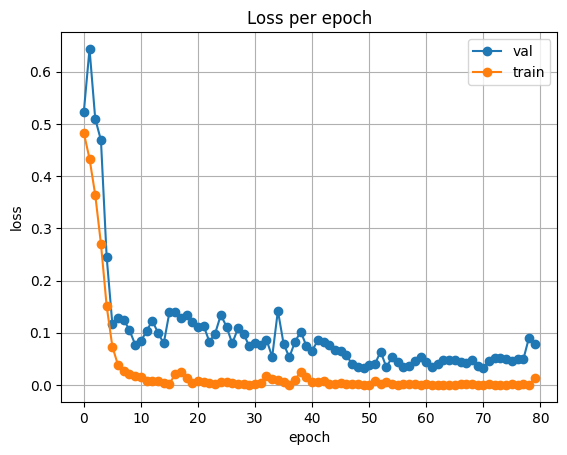

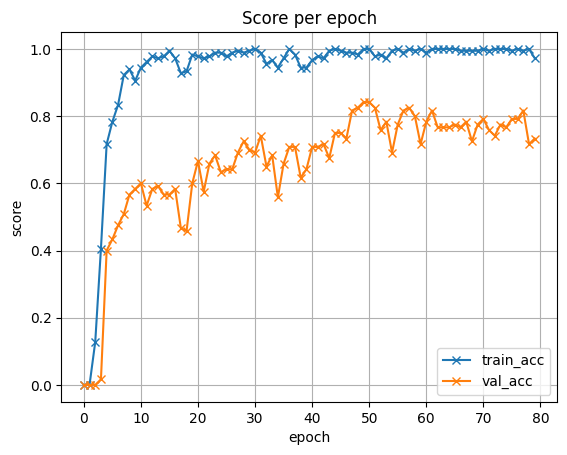

In [34]:
def plot_loss(x, history):
    plt.plot(x, history['val_loss'], label='val', marker='o')
    plt.plot(x, history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()


def plot_acc(x, history):
    plt.plot(x, history['train_acc'], label='train_acc', marker='x')
    plt.plot(x, history['val_acc'], label='val_acc', marker='x')
    plt.title('Score per epoch')
    plt.ylabel('score')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(np.arange(0,epoch), history)
plot_acc(np.arange(0,epoch), history)


In [43]:

net = models.efficientnet_b0()
num_ftrs = net.classifier[1].in_features
net.fc = nn.Linear(num_ftrs, 3)
net=torch.load("/home/cluster/factory_project/classfier_data/trin_code/checkpoints/new/factory_data_b_crop_more_efficientnet_b02/best.pth")

classes = ('Hairiness', 'Silk_scraps', 'Sticky')

class_correct = [0.] * 10
class_total = [0.] * 10 
y_test, y_pred = [] , []
X_test = []

with torch.no_grad():
    for images, labels in val_loader:
        X_test.extend([_ for _ in images])
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i, label in enumerate(labels):
            class_correct[label] += c[i].item()
            class_total[label] += 1
        y_pred.extend(predicted.numpy())
        y_test.extend(labels.cpu().numpy())      
        
for i in range(3):
    print(f"Acuracy of {classes[i]:5s}: {100*class_correct[i]/class_total[i]:2.0f}%")


Acuracy of Hairiness: 80%
Acuracy of Silk_scraps: 80%
Acuracy of Sticky: 92%


In [44]:
from sklearn.metrics import confusion_matrix, classification_report

ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=classes)
print("Accuracy is :",ac) 
print(cr)


Accuracy is : 0.8416666666666667
              precision    recall  f1-score   support

   Hairiness       0.76      0.80      0.78        40
 Silk_scraps       0.82      0.80      0.81        40
      Sticky       0.95      0.93      0.94        40

    accuracy                           0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120



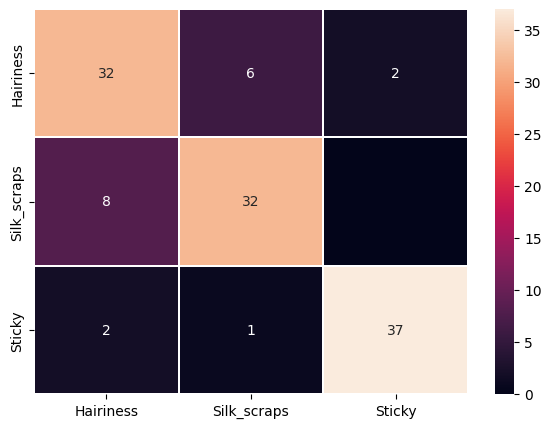

In [45]:
import seaborn as sns, pandas as pd

labels = pd.DataFrame(cm).applymap(lambda v: f"{v}" if v!=0 else f"")
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=labels, fmt='s', xticklabels=classes, yticklabels=classes, linewidths=0.1 )
plt.show()
